In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tensornetworks_pytorch.TNModels import PosMPS, Born
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(torch.__version__)

1.8.0.dev20201128


In [6]:
### import data
import pickle
for dataset in [#'biofam',
    'flare','lymphography','spect','tumor','votes']:
    with open('datasets/'+dataset, 'rb') as f:
            a=pickle.load(f)
    X=a[0].astype(int)
    print(dataset)
    print("\tdata shape:", X.shape)
    print(f"\trange of X values: {X.min()} -- {X.max()}")

def load_dataset(dataset):
    with open('datasets/'+dataset, 'rb') as f:
            a=pickle.load(f)
    X=a[0]
    X=X.astype(int)

    print("\tdata shape:", X.shape)
    print(f"\trange of X values: {X.min()} -- {X.max()} ==> d={X.max()+1}")
    d = X.max()+1
    return X, d

flare
	data shape: (1065, 13)
	range of X values: 0 -- 7
lymphography
	data shape: (148, 19)
	range of X values: 0 -- 7
spect
	data shape: (187, 23)
	range of X values: 0 -- 1
tumor
	data shape: (339, 17)
	range of X values: 0 -- 3
votes
	data shape: (435, 17)
	range of X values: 0 -- 2


In [50]:
### initialize models
dataset = 'lymphography'
print("dataset:", dataset)
X,d = load_dataset(dataset)

D = 4
mps      = PosMPS(X, d, D, homogeneous=False)
mps_hom  = PosMPS(X, d, D, homogeneous=True)

# mps_s    = PosMPS(X, d, D, homogeneous=False, log_stability=True)
# mps_s_hom= PosMPS(X, d, D, homogeneous=True, log_stability=True)

rBorn      = Born(X, d, D, dtype=torch.float, homogeneous=False, log_stability=False) 
rBorn_hom  = Born(X, d, D, dtype=torch.float, homogeneous=True, log_stability=False) 

rBorn_s    = Born(X, d, D, dtype=torch.float, homogeneous=False, log_stability=True) 
rBorn_s_hom= Born(X, d, D, dtype=torch.float, homogeneous=True, log_stability=True) 

cBorn      = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=False)
cBorn_hom  = Born(X, d, D, dtype=torch.cfloat, homogeneous=True, log_stability=False)

cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True)
cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True, log_stability=True)

models     = (
    rBorn, cBorn, rBorn_s, cBorn_s, mps#, mps_c
)
models_hom = (
    rBorn_hom, cBorn_hom, rBorn_s_hom, cBorn_s_hom, mps_hom#, mps_c_hom
)
print("Initializing models:")
for model in (*models, *models_hom):
    print(f"\t{model.core.shape} model type: {model.name}")
    for p in model.parameters():
                if torch.isnan(p).any():
                    print("Model weights contain a NaN value!")

dataset: lymphography
	data shape: (148, 19)
	range of X values: 0 -- 7 ==> d=8
Initializing models:
	torch.Size([19, 8, 4, 4]) model type: Born (torch.float32), Non-homogeneous
	torch.Size([19, 8, 4, 4]) model type: Born (torch.complex64), Non-homogeneous
	torch.Size([19, 8, 4, 4]) model type: Born (torch.float32), Non-homogeneous + log_stability
	torch.Size([19, 8, 4, 4]) model type: Born (torch.complex64), Non-homogeneous + log_stability
	torch.Size([19, 8, 4, 4]) model type: Positive MPS, Non-homogeneous
	torch.Size([8, 4, 4]) model type: Born (torch.float32), Homogeneous
	torch.Size([8, 4, 4]) model type: Born (torch.complex64), Homogeneous
	torch.Size([8, 4, 4]) model type: Born (torch.float32), Homogeneous + log_stability
	torch.Size([8, 4, 4]) model type: Born (torch.complex64), Homogeneous + log_stability
	torch.Size([8, 4, 4]) model type: Positive MPS, Homogeneous


In [53]:
def clip_(grad, clip_val, verbose=False):
    if torch.isnan(grad).any():
        print("│ Hook says: Gradient contains a NaN value!")
    if grad.dtype==torch.cfloat:
        for ext, v in [("min", grad.real.min()),("max", grad.real.max())]:
            if abs(v) > clip_val:
                print(f"clipping real {ext} {v:.2} to size {clip_val}")
        for ext, v in [("min", grad.imag.min()),("max", grad.imag.max())]:
            if abs(v) > clip_val:
                print(f"clipping imag {ext} {1.j*v:.2} to size {clip_val}")
        clipped_grad = torch.complex(grad.real.clamp(-clip_val, clip_val),
                                     grad.imag.clamp(-clip_val, clip_val))
    else:
        for ext, v in [("min", grad.min()),("max", grad.max())]:
            if abs(v) > clip_val:
                print(f"clipping {ext} {v:.2} to size {clip_val}")
        clipped_grad = torch.clamp(grad, -clip_val, clip_val)
    return clipped_grad

def train(self, dataset, batchsize, max_epochs, plot=True, clip=False, **optim_kwargs):
    if clip:
        clip_val=1
        for p in model.parameters():
            p.register_hook(lambda grad: clip_(grad, clip_val, verbose=True))
    trainloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)
    optimizer = torch.optim.SGD(self.parameters(), **optim_kwargs)
    early_stopping_threshold = 0.0001 # min difference in epoch loss
    loss_values = [] # store by-epoch avg loss values
    print('╭───────────────────────────')
    print(f"│Training {self.name}.")
    av_batch_loss_running = -1000
    with tqdm(range(max_epochs), leave=True) as tepochs:
        for epoch in tepochs:
            batch_loss = []
            with tqdm(trainloader, unit="batch", leave=False, desc=f"epoch {epoch}") as tepoch:
                for batch in tepoch:
                    for p in self.parameters():
                        if torch.isnan(p).any():
                            print("│ loss values:", *(f"{x:.3f}" for x in loss_values))
                            print("└────Stopped. After updating, model weights contain a NaN value!")
                            if plot:
                                plt.plot(loss_values)
                                plt.show()
                            return loss_values
                    self.zero_grad()
                    neglogprob = 0
                    for i,x in enumerate(batch):
                        out = self(x)
                        neglogprob -= out
                    loss = neglogprob / len(batch)
                    loss.backward()
                    for p in self.parameters():
                        if torch.isnan(p.grad).any():
                            print("│ loss values:", *(f"{x:.3f}" for x in loss_values))
                            print("└────Stopped. Gradient contains a NaN value!")
                            if plot:
                                plt.plot(loss_values)
                                plt.show()
                            return loss_values
                    optimizer.step()
                    tepoch.set_postfix(loss=loss.item())
                    with torch.no_grad():
                        batch_loss.append(loss.item())
            av_batch_loss = torch.Tensor(batch_loss).mean().item()
            #print(f"ep{epoch} av_batch_loss\t {av_batch_loss}")
            loss_values.append(av_batch_loss)
            tepochs.set_postfix(av_batch_loss=av_batch_loss)
            if abs(av_batch_loss_running - av_batch_loss) < early_stopping_threshold:
                print("└────Early stopping.")
                break
            av_batch_loss_running = av_batch_loss
    print("│ loss values:", *(f"{x:.3f}" for x in loss_values))
    if plot:
        plt.plot(loss_values)
        plt.show()
    print('╰────────Finished─training──\n')
    return loss_values

╭───────────────────────────
│Training Born (torch.complex64), Non-homogeneous + log_stability.


│ Hook says: Gradient contains a NaN value!
│ Hook says: Gradient contains a NaN value!
│ Hook says: Gradient contains a NaN value!
│ Hook says: Gradient contains a NaN value!
│ Hook says: Gradient contains a NaN value!
│ Hook says: Gradient contains a NaN value!
│ loss values:
└────Stopped. Gradient contains a NaN value!



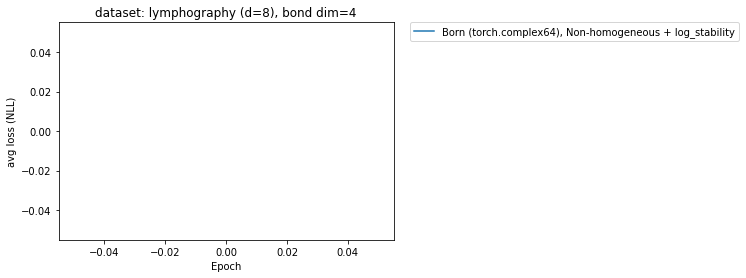

In [54]:
modelhom_loss_values={}
for model in [cBorn_s]:
    loss_values = train(model, X, batchsize=70, plot=False, clip=True, max_epochs = 5, lr=0.1)
    plt.plot(loss_values, label=model.name)
    plt.ylabel('avg loss (NLL)')
    plt.xlabel('Epoch')
    plt.title(f"dataset: {dataset} (d={d}), bond dim={D}")
    modelhom_loss_values["model.name"]=loss_values
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [ ]:
modelhom_loss_values={}
for model in models_hom:
    loss_values = train(model, X, batchsize=35, plot=False, clip=True, max_epochs = 100, lr=0.1)
    plt.plot(loss_values, label=model.name)
    plt.ylabel('avg loss (NLL)')
    plt.xlabel('Epoch')
    plt.title(f"dataset: {dataset} (d={d}), bond dim={D}")
    modelhom_loss_values["model.name"]=loss_values
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [ ]:
model_loss_values={}
for model in models:
    loss_values = train(model, X, batchsize=30, plot=False, clip=False, max_epochs = 100, lr=0.1)
    plt.plot(loss_values, label=model.name)
    plt.ylabel('avg loss (NLL)')
    plt.xlabel('Epoch')
    plt.title(f"dataset: {dataset} (d={d}), bond dim={D}")
    model_loss_values["model.name"]=loss_values
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()